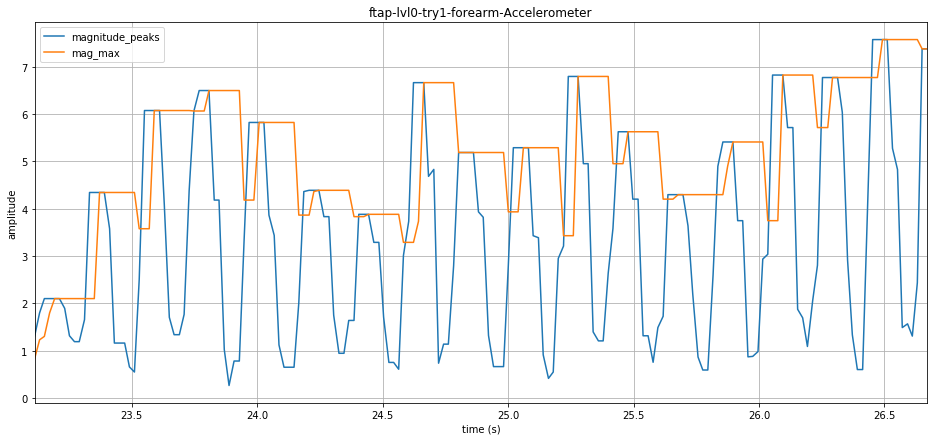

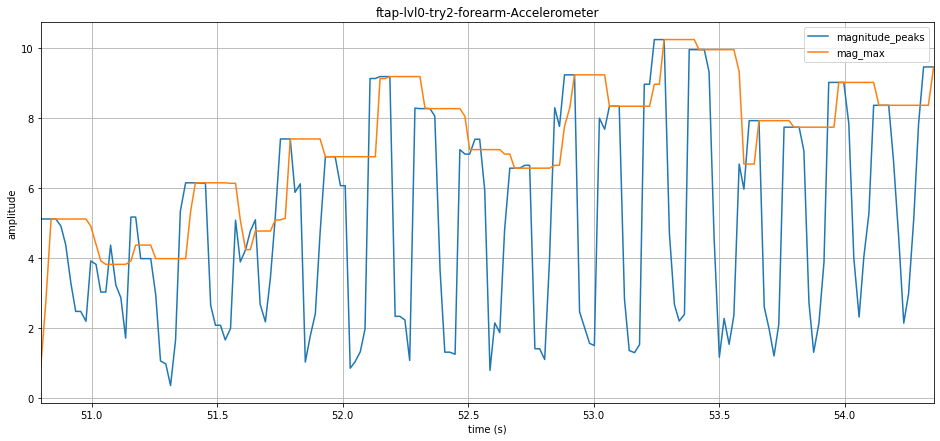

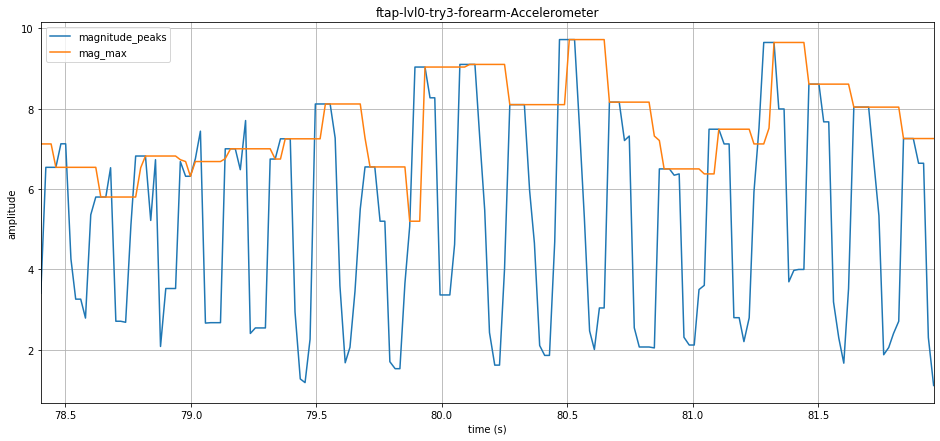

In [6]:
from os import listdir
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def cal_mean(c):
    # calculate mean of 3 different tries
    return np.around(np.add.reduceat(c, np.arange(0, len(c), 3))/3,3).round(1)

def plt_individual_graphs(df_main, df_, spectrogram, title):
    fig_size = (16,7)
    if True:
#     if ('ftap' in title):
#         if True:
        if ('Accelerometer' in title):
            if True:
#             if ('try1' in title):
                # plot magnitude graph
                df = df_main[20:200]
                ax1=df.plot(x='elapsed (s)',y=['magnitude_peaks','mag_max'],
                            grid=True,figsize=fig_size,
                            title=title)
                ax1.set_xlabel('time (s)')
                ax1.set_ylabel('amplitude')
                
                 envelope(df)

                # plot frequency over time
                ax2=df_.plot(x='time',y='freq',
                         grid=True,figsize=fig_size,ylim=[0,15],
                         title=title)
                ax2.set_xlabel('time (s)')
                ax2.set_ylabel('frequency (Hz)')

                # plot spectrogram
                plt.figure(figsize=fig_size)
                plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
                plt.title(title)
                plt.ylabel('Frequency band')
                plt.xlabel('Time window')
                plt.tight_layout()
    
# plot bubble graph for amplitude
def plt_bubble_amp(df, file, counter, axes):
    ax1,ax2,ax3,ax4 = axes
    if 'Accelerometer' in file:
        if 'forearm' in file:
            ax1.scatter(df.index[30:],np.ones(len(df.index[30:]))*counter[0],
                        c=df['max'][30:],cmap="Greens",
                        s=(df['max'][30:]*2.5**5.5).apply(int))
            counter[0]+=1
        elif 'wrist' in file:
            ax2.scatter(df.index[30:],np.ones(len(df.index[30:]))*counter[1],
                        c=df['max'][30:],cmap="Greens",
                        s=(df['max'][30:]*2.5**5.5).apply(int))
            counter[1]+=1
    elif 'Gyroscope' in file:
        if 'forearm' in file:
            ax3.scatter(df.index[30:],np.ones(len(df.index[30:]))*counter[2],
                        c=df['max'][30:],cmap="Greens",
                        s=(df['max'][30:]**1.7).apply(int))
            counter[2]+=1
        elif 'wrist' in file:
            ax4.scatter(df.index[30:],np.ones(len(df.index[30:]))*counter[3],
                        c=df['max'][30:],cmap="Greens",
                        s=(df['max'][30:]**1.7).apply(int))
            counter[3]+=1
            
    return counter

def test_cal(df, window):
    df['x_peaks'] = df['x'].diff().rolling(window).max() - df['x'].diff().rolling(window).min()
    df['y_peaks'] = df['y'].diff().rolling(window).max() - df['y'].diff().rolling(window).min()
    df['z_peaks'] = df['z'].diff().rolling(window).max() - df['z'].diff().rolling(window).min()
    df['magnitude_peaks'] = df['z_peaks']**2# + df['x_peaks']**2 + df['y_peaks']**2
    df['magnitude_peaks'] = (df['magnitude_peaks'].apply(math.sqrt))*9.81
    df['mag_max'] = df['magnitude_peaks'].rolling(9).quantile(.75)
    return df


def envelope(df):
    df['time (-00:00)'] = df['time (-00:00)'].apply(pd.to_datetime)
    df = df.set_index(['time (-00:00)'])
    
    summary = (df.resample('0.002S', label='right', closed='right')
             .agg({"magnitude_peaks":{"upper":"max"}}))
    summary.columns = summary.columns.droplevel(0)
    
    df2 = df.merge(summary, how='left', left_index=True, right_index=True)
    df2.upper.interpolate(inplace=True)
    
    plot_cols = ['magnitude_peaks','upper']
    df2[plot_cols].plot(figsize=(16,7))
    
def cal_magnitude(df, file, window):
    # combine triaxial data into one singular magnitude data
    if 'Accelerometer' in file:
        df['x'] = df.loc[window-1:,'x-axis (g)']-df['x-axis (g)'].rolling(window).mean()[window-1:]
        df['y'] = df.loc[window-1:,'y-axis (g)']-df['y-axis (g)'].rolling(window).mean()[window-1:]
        df['z'] = df.loc[window-1:,'z-axis (g)']-df['z-axis (g)'].rolling(window).mean()[window-1:]
        df['magnitude'] = df['x']**2 + df['y']**2 + df['z']**2
        df['magnitude'] = (df['magnitude'].apply(math.sqrt))*9.81
        
    elif 'Gyroscope' in file:
        df['x'] = df.loc[window-1:,'x-axis (deg/s)']-df['x-axis (deg/s)'].rolling(window).mean()[window-1:]
        df['y'] = df.loc[window-1:,'y-axis (deg/s)']-df['x-axis (deg/s)'].rolling(window).mean()[window-1:]
        df['z'] = df.loc[window-1:,'z-axis (deg/s)']-df['x-axis (deg/s)'].rolling(window).mean()[window-1:]
        df['magnitude'] = df['x']**2 + df['y']**2 + df['z']**2
        df['magnitude'] = df['magnitude'].apply(math.sqrt)
        
    return df

# calculate rolling frequency
def cal_freq(df):
    freqs, times, spectrogram = signal.spectrogram(df['magnitude'].values, fs=50.0, nperseg=70, noverlap=70-1)
    df_ = pd.DataFrame({'time':times, 'freq':[freqs[i] for i in np.argmax(spectrogram,0)]})
    df_['max'] = df_['freq'].rolling(30).max()
    return df_, spectrogram

# repivot dataframe
def rearrange_stats_table(info):
    info['name'] = info['test'].apply(lambda x:x.split('-')[0])
    info['level'] = info['test'].apply(lambda x:x.split('-')[1])
    info['try'] = info['test'].apply(lambda x:x.split('-')[2])

    info = pd.DataFrame({'name': info['name'].iloc[::2].values,
                         'level': info['level'].iloc[::2].apply(lambda x:int(x[-1])).values,
                         'try': info['try'].iloc[::2].apply(lambda x:int(x[-1])).values,
                         'mean_accel_amp': info['mean_amp'].iloc[::2].values,
                         'mean_gyro_amp': info['mean_amp'].iloc[1::2].values,
                         'std_accel_amp': info['std_amp'].iloc[::2].values,
                         'std_gyro_amp': info['std_amp'].iloc[1::2].values,
                         'mean_accel_freq': info['mean_freq'].iloc[::2].values,
                         'mean_gyro_freq': info['mean_freq'].iloc[1::2].values,
                         'std_accel_freq': info['std_freq'].iloc[::2].values,
                         'std_gyro_freq': info['std_freq'].iloc[1::2].values})

    info = pd.DataFrame({'name': info['name'].iloc[::6].values,
                         'level': info['level'].iloc[::6].values,
                         'mean_acc_forearm_amp': cal_mean(info['mean_accel_amp'].iloc[::2].values),
                         'mean_acc_wrist_amp': cal_mean(info['mean_accel_amp'].iloc[1::2].values),
                         'mean_gyr_forearm_amp': cal_mean(info['mean_gyro_amp'].iloc[::2].values),
                         'mean_gyr_wrist_amp': cal_mean(info['mean_gyro_amp'].iloc[1::2].values),
                         'std_acc_forearm_amp': cal_mean(info['std_accel_amp'].iloc[::2].values),
                         'std_acc_wrist_amp': cal_mean(info['std_accel_amp'].iloc[1::2].values),
                         'std_gyr_forearm_amp': cal_mean(info['std_gyro_amp'].iloc[::2].values),
                         'std_gyr_wrist_amp': cal_mean(info['std_gyro_amp'].iloc[1::2].values),
                         'mean_acc_forearm_freq': cal_mean(info['mean_accel_freq'].iloc[::2].values),
                         'mean_acc_wrist_freq': cal_mean(info['mean_accel_freq'].iloc[1::2].values),
                         'mean_gyr_forearm_freq': cal_mean(info['mean_gyro_freq'].iloc[::2].values),
                         'mean_gyr_wrist_freq': cal_mean(info['mean_gyro_freq'].iloc[1::2].values),
                         'std_acc_forearm_freq': cal_mean(info['std_accel_freq'].iloc[::2].values),
                         'std_acc_wrist_freq': cal_mean(info['std_accel_freq'].iloc[1::2].values),
                         'std_gyr_forearm_freq': cal_mean(info['std_gyro_freq'].iloc[::2].values),
                         'std_gyr_wrist_freq': cal_mean(info['std_gyro_freq'].iloc[1::2].values)})
    
    return info

# MAIN FUNCTION
def main(path='/', window=3, truncate=None, info=None, counter=[0,0,0,0], axes=[]):
    filenames = [filename for filename in listdir(path) if filename.endswith('.csv')]
    
    for i in range(len(filenames)):
        file = filenames[i]
        title_main = file.split('_')[0]

        # extract dataframe
        df_main = pd.read_csv(path + file)

        # combine triaxial data into one singular magnitude data
        df_main = cal_magnitude(df_main, file, window)
        
        # extract umbrella curve
        df_main['max'] = df_main['magnitude'].rolling(30).max()
        
        df_main = test_cal(df_main, 5)
        
#         df_, spectrogram = cal_freq(df_main)
#         plt_individual_graphs(df_main, df_, spectrogram, title_main+'-'+file.split('_')[4])
        
        for test in range(3):
            # include tries in title
            title = title_main.split('-')[0] + '-' + title_main.split('-')[1] + '-try' + str(test+1) + '-' + title_main.split('-')[2]
            
            # truncate signal beyond start and end times
            if (truncate is not None) and (truncate[i][test] != ()):
                df = df_main[(df_main['elapsed (s)'] <= truncate[i][test][1]) & (df_main['elapsed (s)'] >= truncate[i][test][0])]
                df.reset_index(inplace=True)
            else:
                df = df_main

            # calculate rolling frequency
            df_, spectrogram = cal_freq(df)

            # gather information on amplitude
            stats = df.describe().loc[:,['max','magnitude']].T
            # gather information on frequency
            stats_ = df_.describe().loc[:,['max','freq']].T

#             # append into dataframe
#             info = info.append({
#                 'test': title,
#                 'mean_amp': stats['mean'][0],
#                 'std_amp': stats['std'][1],
#                 'mean_freq': stats_['mean'][0],
#                 'std_freq': stats_['std'][1]
#             }, ignore_index=True)

#             # ONLY UNCOMMENT WHEN PLOTTING GRAPHS
            plt_individual_graphs(df, df_, spectrogram, title+'-'+file.split('_')[4])
#             counter = plt_bubble_amp(df, file, counter, axes)
#             counter = plt_bubble_freq(df_, file, counter, axes)
        break

#     info = rearrange_stats_table(info)
    
    return info, axes

info = pd.DataFrame(columns=['test','mean_amp','std_amp','mean_freq','std_freq'])

# real data
info, axes = main(path='Patient001-2019-12-05/',
                  truncate = [
                              # ftap lvl0
                              [(22.7,34),(50.4,62),(78,89)],[(22.7,34),(50.4,62),(78,89)],
                              [(36,46),(68,78.8),(95,106)],[(36,46),(68,78.8),(95,106)],
                              # ftap lvl1
                              [(20.5,32),(54,65),(86,97.5)],[(20.5,32),(54,65),(86,97.5)],
                              [(25,38),(62,73),(94.3,106)],[(25,38),(62,73),(94.3,106)],
                              # hmove lvl0
                              [(23,30),(51.5,59),(79.5,87)],[(23,30),(51.5,59),(79.5,87)],
                              [(22,29),(50,58.5),(79,87.8)],[(22,29),(50,58.5),(79,87.8)],
                              # prosup lvl0
                              [(22.5,28.5),(49.5,57.8),(78.5,89)],[(22.5,28.5),(49.5,57.8),(78.5,89)],
                              [(23.5,30.9),(52,61),(82,90.7)],[(23.5,30.9),(52,61),(82,90.7)],
                              # ttap lvl0
                              [(21,31.5),(51,62),(83.4,92.5)],[(21,31.5),(51,62),(83.4,92.5)],
                              [(24,36),(56.5,67.5),(88,99)],[(24,36),(56.5,67.5),(88,99)],
                              # tugt lvl0
                              [(11,20),(30,39),(49,57)],[(11,20),(30,39),(49,57)],
                              [(11,21),(30,40),(49,58)],[(11,21),(30,40),(49,58)]
                              ],
                  info=info)

# info.T